In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# # Pairplot for numerical variables
# sns.pairplot(df, hue='Exited', diag_kind='kde')
# plt.show()

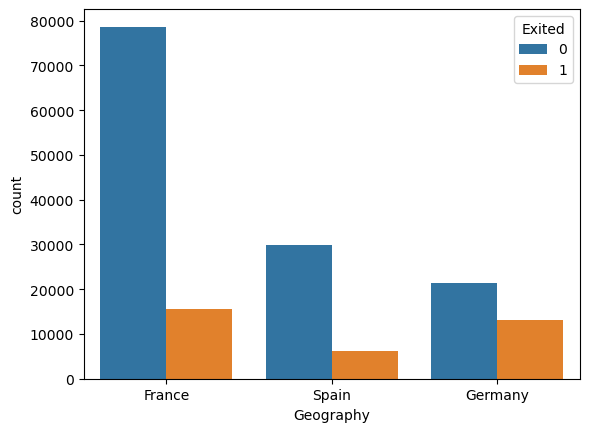

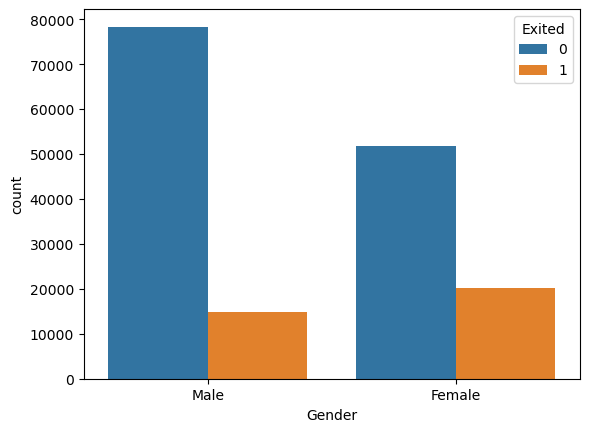

In [5]:
# Countplot for categorical variables
sns.countplot(x='Geography', hue='Exited', data=df)
plt.show()

sns.countplot(x='Gender', hue='Exited', data=df)
plt.show()

In [6]:
# Drop irrelevant columns
df = df.drop(['id', 'CustomerId', 'Surname'], axis=1)
df_test = test_df.drop(['id', 'CustomerId', 'Surname'], axis=1)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df_test['Gender'] = label_encoder.transform(df_test['Gender'])

# One-hot encode the 'Geography' column
geography_encoder = OneHotEncoder(drop='first', sparse_output=False)
df_geography_encoded = pd.DataFrame(geography_encoder.fit_transform(df[['Geography']]))
df_test_geography_encoded = pd.DataFrame(geography_encoder.transform(df_test[['Geography']]))

# Concatenate the one-hot encoded columns back to the original DataFrames
df = pd.concat([df, df_geography_encoded], axis=1)
df_test = pd.concat([df_test, df_test_geography_encoded], axis=1)

# Drop the original 'Geography' column
df = df.drop(['Geography'], axis=1)
df_test = df_test.drop(['Geography'], axis=1)

# Convert column names to string type
df.columns = df.columns.astype(str)
df_test.columns = df_test.columns.astype(str)

# Split into features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
df_test = scaler.transform(df_test)

In [7]:
# Define a list of classifiers with their respective parameter grids
classifiers = [
#  ('AdaBoost', AdaBoostClassifier(),
#      {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}),
#     ('Gradient Boosting', GradientBoostingClassifier(),
#      {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}),
#     ('Neural Network', MLPClassifier(),
#      {'hidden_layer_sizes': [(50, 50), (100,)], 'alpha': [0.0001, 0.001, 0.01], 'max_iter': [1000]}),
    ('XGBoost', XGBClassifier(n_jobs=-1),
     {'n_estimators': [200],
      'learning_rate': [0.1],
      'max_depth': [4],
      'subsample': [1],
      'colsample_bytree': [1],
      'gamma': [0],
      'min_child_weight': [3]})
]

# Create variables to store the best model and its parameters
best_auc = 0  # Initialize the best AUC score
best_model_name = None
best_params = None
best_model = None

# Iterate over classifiers with tqdm for a progress bar
for clf_name, clf, param_grid in tqdm(classifiers, desc='Classifiers Progress'):
    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    current_best_params = grid_search.best_params_

    # Use the best hyperparameters to train the model
    current_best_model = clf.set_params(**current_best_params)
    current_best_model.fit(X_train, y_train)

    # Get the AUC score on the validation set
    auc_score = roc_auc_score(y_test, current_best_model.predict_proba(X_test)[:, 1])

    # Check if the current model has a higher AUC score
    if auc_score > best_auc:
        best_auc = auc_score
        best_model_name = clf_name
        best_params = current_best_params
        best_model = current_best_model

# Print the best AUC score and the corresponding model name and parameters
print(f"Best AUC Score: {best_auc}")
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")

Classifiers Progress: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]

Best AUC Score: 0.8911350555538814
Best Model: XGBoost
Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1}


In [8]:
# Train the best model using the best hyperparameters
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

With a ROC-AUC score of 0.8911, i will continue to make my predictions and store them in csv for submission.

In [9]:
# Make predictions on the test set using the best model
preds = best_model.predict_proba(df_test)[:, 1]

In [10]:
# Assuming 'id_column' is the column containing IDs in your test dataset
df_test_id_column = pd.read_csv('test.csv')['id']

# Create a DataFrame with 'id' and 'Exited' columns
final_submission_df = pd.DataFrame({'id': df_test_id_column, 'Exited': preds})

# Save the final submission file to csv
final_submission_df.to_csv('final_submission.csv', index=False)